## Distracted Driver Detection using DL

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.models import Model
from tensorflow import keras
from keras import layers

In [2]:
TRAINING_EPOCHS = 10
BATCH_SIZE = 32

#### Data Preparation

In [6]:
data_dir = '/Users/omachrekar/My Work/Artificial Intelligence Projects/Distracted Driver Detection/Dataset/test'
image_paths = []
labels = []

# Iterate over the subdirectories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Get the list of image files in the class directory
        image_files = os.listdir(class_dir)
        # Append the image paths and labels
        image_paths.extend([os.path.join(class_dir, img_file) for img_file in image_files])
        labels.extend([class_name] * len(image_files))

# Create a DataFrame from the image paths and labels
data = {'filename': image_paths, 'label': labels}
test_df = pd.DataFrame(data)

# Print the resulting DataFrame
print(test_df.head())

                                            filename        label
0  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
1  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
2  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
3  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
4  /Users/omachrekar/My Work/Artificial Intellige...  using_radio


In [7]:
test_df['label'].value_counts()

using_phone        929
texting            923
safe_driving       499
drinking           467
using_radio        464
talking            427
reaching_behind    401
hair_and_makeup    384
Name: label, dtype: int64

<Axes: title={'center': 'Test data distribution'}, ylabel='label'>

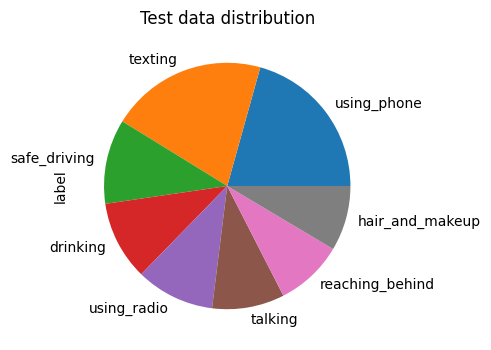

In [8]:
# plot a pie chart
test_df['label'].value_counts().plot(kind='pie', figsize=(4, 4), title='Test data distribution')

In [9]:
data_dir = '/Users/omachrekar/My Work/Artificial Intelligence Projects/Distracted Driver Detection/Dataset/train'
image_paths = []
labels = []

# Iterate over the subdirectories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Get the list of image files in the class directory
        image_files = os.listdir(class_dir)
        # Append the image paths and labels
        image_paths.extend([os.path.join(class_dir, img_file) for img_file in image_files])
        labels.extend([class_name] * len(image_files))

# Create a DataFrame from the image paths and labels
data = {'filename': image_paths, 'label': labels}
train_df = pd.DataFrame(data)

# Print the resulting DataFrame
print(train_df.head())

                                            filename        label
0  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
1  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
2  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
3  /Users/omachrekar/My Work/Artificial Intellige...  using_radio
4  /Users/omachrekar/My Work/Artificial Intellige...  using_radio


In [10]:
train_df['label'].value_counts()

using_phone        3715
texting            3691
safe_driving       1991
drinking           1859
using_radio        1849
talking            1703
reaching_behind    1602
hair_and_makeup    1528
Name: label, dtype: int64

<Axes: title={'center': 'Train data distribution'}, ylabel='label'>

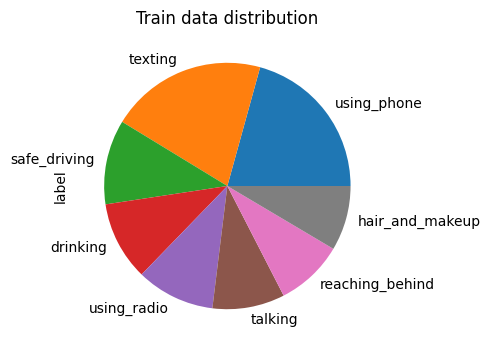

In [11]:
# plot a pie chart
train_df['label'].value_counts().plot(kind='pie', figsize=(4, 4), title='Train data distribution')

In [12]:
train_df['filename'][1]

'/Users/omachrekar/My Work/Artificial Intelligence Projects/Distracted Driver Detection/Dataset/train/using_radio/img_26120.jpg'

In [13]:
main_path = '/Users/omachrekar/My Work/Artificial Intelligence Projects/Distracted Driver Detection/Dataset'

In [14]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = main_path + '/train', # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (180, 180), # image height , image width
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    # validate_filenames=False
    )

Found 17938 validated image filenames belonging to 8 classes.


In [15]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path + '/test', # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  = "rgb",
    target_size = (180, 180), # image height , image width
    class_mode = 'categorical',
    batch_size  = 32,
    shuffle = True,
    seed = 42)

Found 4486 validated image filenames belonging to 8 classes.


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [16]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [17]:
class_names

['drinking',
 'hair_and_makeup',
 'reaching_behind',
 'safe_driving',
 'talking',
 'texting',
 'using_phone',
 'using_radio']

#### Model Setup

In [15]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [59]:
from keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [66]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    history = model.fit(train_generator,
                        validation_data = test_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

#### Approach 1: VGG16

In [69]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (180, 180, 3)
                             )

vgg16_model = create_model(vgg16_base_model)
vgg16_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0   

In [70]:
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/10


2023-07-01 01:00:55.413455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 01:00:55.426936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.2925

2023-07-01 01:03:35.807928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 01:03:35.817348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - 203s 361ms/step - loss: 1.8506 - accuracy: 0.2925 - val_loss: 1.4269 - val_accuracy: 0.5392
Epoch 2/10
561/561 [==============================] - 247s 439ms/step - loss: 1.3096 - accuracy: 0.5365 - val_loss: 0.9911 - val_accuracy: 0.6667
Epoch 3/10
561/561 [==============================] - 247s 440ms/step - loss: 1.0303 - accuracy: 0.6371 - val_loss: 0.9451 - val_accuracy: 0.6534
Epoch 4/10
561/561 [==============================] - 246s 438ms/step - loss: 0.8853 - accuracy: 0.6908 - val_loss: 0.6881 - val_accuracy: 0.7724
Epoch 5/10
561/561 [==============================] - 247s 440ms/step - loss: 0.7941 - accuracy: 0.7253 - val_loss: 0.6297 - val_accuracy: 0.7858
Epoch 6/10
561/561 [==============================] - 249s 444ms/step - loss: 0.7391 - accuracy: 0.7494 - val_loss: 0.6150 - val_accuracy: 0.7974
Epoch 7/10
561/561 [==============================] - 249s 443ms/step - loss: 0.6901 - accuracy: 0.7649 - val_loss: 0.5410 - val_accura

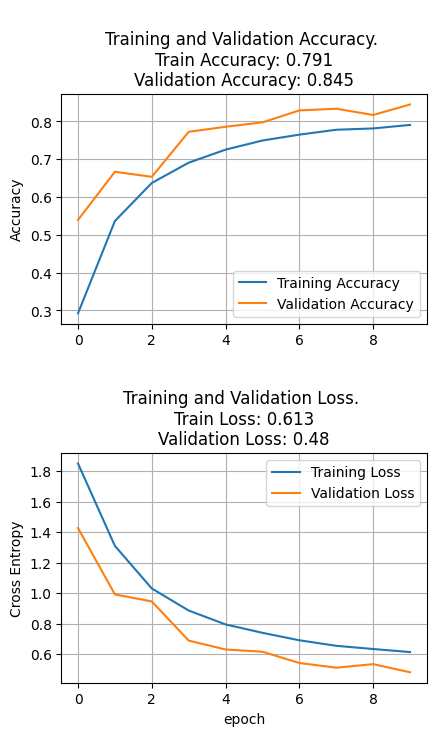

In [71]:
plot_history(history)

#### Approach 2: Inception

In [72]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (180, 180, 3)
                     )

inception_model = create_model(inception_base_model)
inception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 89, 89, 32)           864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 89, 89, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 89, 89, 32)           0         ['batch_normalization[0]

In [73]:
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/10


2023-07-01 01:46:49.881505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 01:46:50.021273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - ETA: 0s - loss: 1.8514 - accuracy: 0.2851

2023-07-01 01:49:06.964744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 01:49:07.116646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - 183s 317ms/step - loss: 1.8514 - accuracy: 0.2851 - val_loss: 1.5658 - val_accuracy: 0.4184
Epoch 2/10
561/561 [==============================] - 213s 379ms/step - loss: 1.6269 - accuracy: 0.3695 - val_loss: 1.3892 - val_accuracy: 0.4853
Epoch 3/10
561/561 [==============================] - 209s 372ms/step - loss: 1.5035 - accuracy: 0.4281 - val_loss: 1.2105 - val_accuracy: 0.5568
Epoch 4/10
561/561 [==============================] - 210s 374ms/step - loss: 1.4019 - accuracy: 0.4719 - val_loss: 1.2262 - val_accuracy: 0.5502
Epoch 5/10
561/561 [==============================] - 212s 377ms/step - loss: 1.3493 - accuracy: 0.4931 - val_loss: 1.1565 - val_accuracy: 0.6070
Epoch 6/10
561/561 [==============================] - 213s 380ms/step - loss: 1.2847 - accuracy: 0.5216 - val_loss: 1.0594 - val_accuracy: 0.6438
Epoch 7/10
561/561 [==============================] - 216s 385ms/step - loss: 1.2308 - accuracy: 0.5419 - val_loss: 0.9949 - val_accura

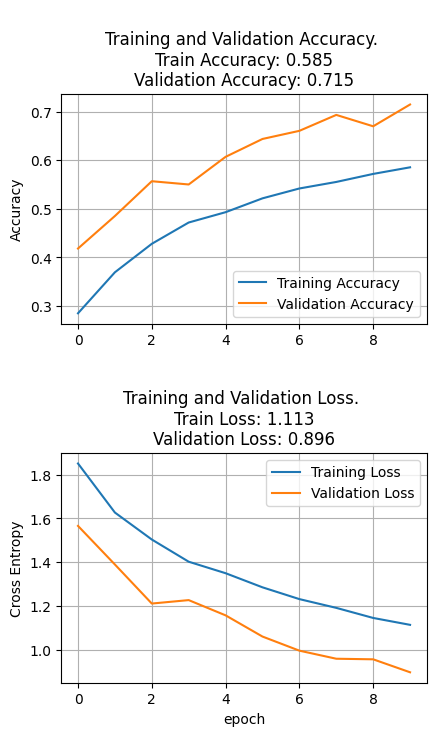

In [74]:
plot_history(history)

#### Approach 3: Xception

In [75]:
# load the xception architecture with imagenet weights as base
xception_base_model = tf.keras.applications.xception.Xception(
                                 include_top = False,
                                 weights = 'imagenet',
                                 input_shape = (180, 180, 3)
                                 )

xception_model = create_model(xception_base_model)
xception_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 89, 89, 32)           864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 89, 89, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 89, 89, 32)           0         ['block1_conv1_bn[0][0]'

In [76]:
history = fit_model(xception_model, xception_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/10


2023-07-01 02:23:56.872496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 02:23:56.912068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - ETA: 0s - loss: 1.5697 - accuracy: 0.4163

2023-07-01 02:26:24.625301: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 02:26:24.658780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - 196s 346ms/step - loss: 1.5697 - accuracy: 0.4163 - val_loss: 1.0711 - val_accuracy: 0.6275
Epoch 2/10
561/561 [==============================] - 226s 403ms/step - loss: 1.1117 - accuracy: 0.5979 - val_loss: 0.8529 - val_accuracy: 0.7055
Epoch 3/10
561/561 [==============================] - 226s 402ms/step - loss: 0.9333 - accuracy: 0.6682 - val_loss: 0.7125 - val_accuracy: 0.7606
Epoch 4/10
561/561 [==============================] - 227s 404ms/step - loss: 0.8381 - accuracy: 0.7014 - val_loss: 0.6080 - val_accuracy: 0.8096
Epoch 5/10
561/561 [==============================] - 226s 403ms/step - loss: 0.7814 - accuracy: 0.7254 - val_loss: 0.6444 - val_accuracy: 0.7856
Epoch 6/10
561/561 [==============================] - 225s 401ms/step - loss: 0.7100 - accuracy: 0.7528 - val_loss: 0.5289 - val_accuracy: 0.8286
Epoch 7/10
561/561 [==============================] - 227s 404ms/step - loss: 0.6688 - accuracy: 0.7673 - val_loss: 0.5043 - val_accura

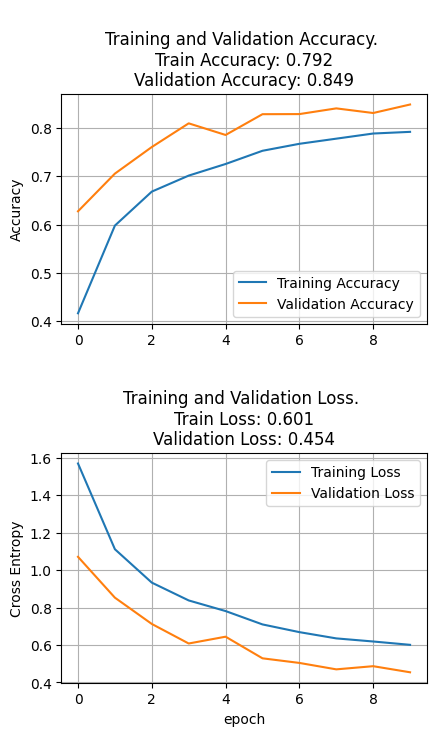

In [77]:
plot_history(history)

#### Approach 4: CNN

In [17]:
# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator)

Epoch 1/10


2023-07-01 11:09:49.092026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 11:09:49.101423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - ETA: 0s - loss: 1.4615 - accuracy: 0.4665

2023-07-01 11:11:24.415671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-01 11:11:24.420507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


561/561 [==============================] - 107s 189ms/step - loss: 1.4615 - accuracy: 0.4665 - val_loss: 0.6203 - val_accuracy: 0.8065
Epoch 2/10
561/561 [==============================] - 107s 190ms/step - loss: 0.5427 - accuracy: 0.8218 - val_loss: 0.3114 - val_accuracy: 0.9053
Epoch 3/10
561/561 [==============================] - 110s 195ms/step - loss: 0.3106 - accuracy: 0.9026 - val_loss: 0.2438 - val_accuracy: 0.9273
Epoch 4/10
561/561 [==============================] - 107s 191ms/step - loss: 0.2219 - accuracy: 0.9313 - val_loss: 0.1513 - val_accuracy: 0.9543
Epoch 5/10
561/561 [==============================] - 110s 195ms/step - loss: 0.1727 - accuracy: 0.9483 - val_loss: 0.1500 - val_accuracy: 0.9539
Epoch 6/10
561/561 [==============================] - 109s 195ms/step - loss: 0.1425 - accuracy: 0.9557 - val_loss: 0.1379 - val_accuracy: 0.9626
Epoch 7/10
561/561 [==============================] - 110s 196ms/step - loss: 0.1209 - accuracy: 0.9639 - val_loss: 0.1340 - val_accura

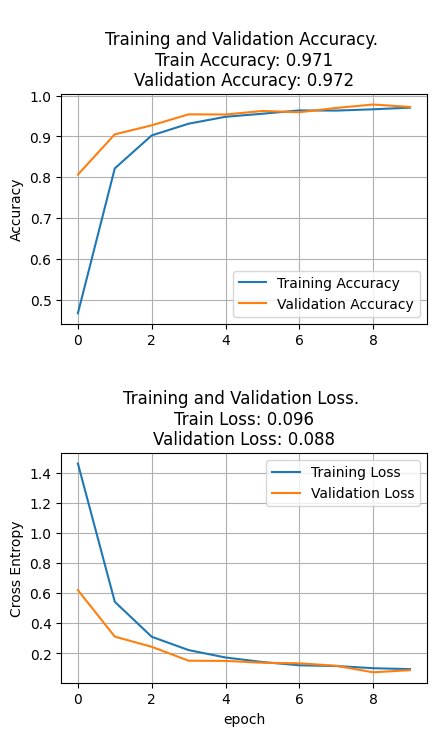

In [20]:
plot_history(history)

In [21]:
model.save('best_model.h5')

/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# import saved model
model = keras.models.load_model('best_model.h5')